### Pet breed classifier model using CNN ###

In [32]:
## Importing modules
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

import torch.nn as nn
import torch.optim as optim

import os
import random

##### Data pre-processing and handling #####

In [2]:
## Data pre-processing 

## Formatter.py is used intially to get dataset that is compatible with ImageFolder

## Defining paths
image_path = Path("Pet_breeds")
train_dir = image_path / "train"
test_dir = image_path / "test"

## Image transform
transform_data = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

## Dataset using ImageFolder
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=transform_data,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=transform_valid)

print(train_data.classes)
print(len(train_data),len(test_data))

from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=32, # how many samples per batch?
                              num_workers=os.cpu_count(), # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=32, 
                             num_workers=os.cpu_count(), 
                             shuffle=False)

train_dataloader, test_dataloader


Using device: cuda
['abyssinian', 'american shorthair', 'beagle', 'boxer', 'bulldog', 'chihuahua', 'corgi', 'dachshund', 'german shepherd', 'golden retriever', 'husky', 'maine coon', 'mumbai cat', 'persian cat', 'pomeranian', 'pug', 'ragdoll cat', 'rottwiler', 'shiba inu', 'siamese cat', 'sphynx', 'yorkshire terrier']
2831 717


(<torch.utils.data.dataloader.DataLoader at 0x221d5b1e240>,
 <torch.utils.data.dataloader.DataLoader at 0x221d5af7b30>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


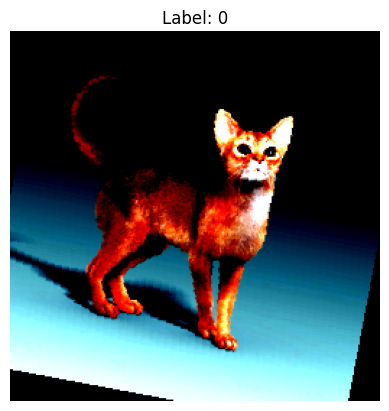

In [3]:
def show_image(tensor, title=None):
    # Transpose the tensor from (C, H, W) to (H, W, C) for display
    image = tensor.permute(1, 2, 0).numpy()
    
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

sample_image, sample_label = train_data[5]

show_image(sample_image, title=f'Label: {sample_label}')

##### CNN model architecture #####

In [4]:
class PetBreedModel(nn.Module):
    def __init__(self, input_shape:int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
            out_channels = 8,
            kernel_size = 3,
            stride = 1,
            padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(in_channels=8,
            out_channels = 16,
            kernel_size = 3,
            stride = 1,
            padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*64*64, out_features=69),
            nn.ReLU(),
            nn.Linear(69, 23)
        )
     
    def forward(self,x:torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x



##### Training and testing Functions #####

In [56]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()

    train_loss, train_acc = 0,0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred,y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    return train_loss/len(dataloader), train_acc/len(dataloader)

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()

    test_loss, test_acc = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        test_loss += loss.item()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        test_acc += (y_pred_class == y).sum().item()/len(y_pred)
    
    return test_loss/len(dataloader), test_acc/len(dataloader)


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs):
    
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)

        test_loss, test_acc = test_step(model = model,
                                           dataloader=test_dataloader,
                                           loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculations
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the class with the highest score
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    #class_report = classification_report(all_labels, all_preds, target_names=dataloader.dataset.classes)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    #print("\nClassification Report:\n", class_report)

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataloader.dataset.classes, yticklabels=dataloader.dataset.classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()




##### Running the model #####

In [6]:
model = PetBreedModel(input_shape=3,
                      output_shape=len(train_data.classes)).to(device)

## Loss function and Optimizer
loss_function = nn.CrossEntropyLoss()
Optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

EPOCHS = 15

model_results = train(model = model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=Optimizer,
                      loss_fn=loss_function,
                      epochs=EPOCHS)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1823 | train_acc: 0.0450 | test_loss: 3.0258 | test_acc: 0.0760
Epoch: 2 | train_loss: 2.9500 | train_acc: 0.1085 | test_loss: 2.9404 | test_acc: 0.1155
Epoch: 3 | train_loss: 2.8063 | train_acc: 0.1634 | test_loss: 2.8196 | test_acc: 0.1412
Epoch: 4 | train_loss: 2.6929 | train_acc: 0.2006 | test_loss: 2.7740 | test_acc: 0.1562
Epoch: 5 | train_loss: 2.5950 | train_acc: 0.2199 | test_loss: 2.7314 | test_acc: 0.1596
Epoch: 6 | train_loss: 2.4843 | train_acc: 0.2576 | test_loss: 2.6043 | test_acc: 0.2145
Epoch: 7 | train_loss: 2.3687 | train_acc: 0.2796 | test_loss: 2.6822 | test_acc: 0.2125
Epoch: 8 | train_loss: 2.2767 | train_acc: 0.3125 | test_loss: 2.6463 | test_acc: 0.2070
Epoch: 9 | train_loss: 2.1230 | train_acc: 0.3517 | test_loss: 2.7421 | test_acc: 0.2030
Epoch: 10 | train_loss: 1.9607 | train_acc: 0.4114 | test_loss: 2.7647 | test_acc: 0.2124
Epoch: 11 | train_loss: 1.8298 | train_acc: 0.4495 | test_loss: 2.7401 | test_acc: 0.2097
Epoch: 12 | train_l

Accuracy: 0.2343
Precision: 0.2245
Recall: 0.2343
F1 Score: 0.2224

Classification Report:
                     precision    recall  f1-score   support

        abyssinian       0.32      0.47      0.38        34
american shorthair       0.32      0.27      0.30        33
            beagle       0.43      0.39      0.41        33
             boxer       0.17      0.18      0.17        34
           bulldog       0.09      0.16      0.12        31
         chihuahua       0.07      0.03      0.04        33
             corgi       0.13      0.15      0.14        33
         dachshund       0.14      0.12      0.13        33
   german shepherd       0.12      0.12      0.12        33
  golden retriever       0.19      0.15      0.17        33
             husky       0.30      0.21      0.25        33
        maine coon       0.17      0.16      0.16        31
        mumbai cat       0.47      0.50      0.48        28
       persian cat       0.12      0.15      0.14        33
       

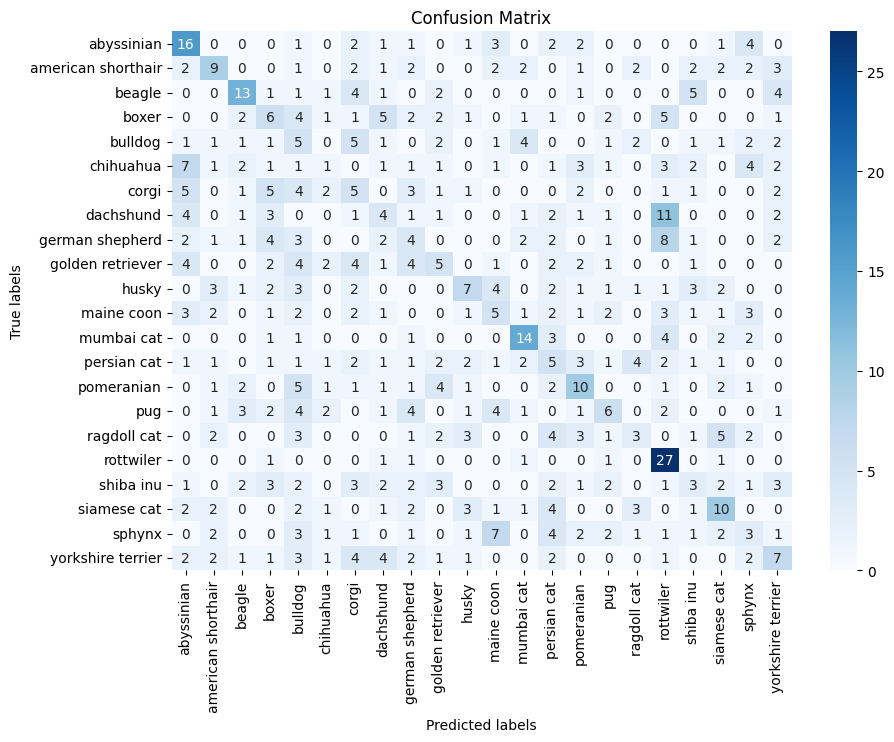

In [19]:
## Custom CNN Evaluation
evaluate_model(model,test_dataloader)


### Template function for finetuning Pretrained models ###

In [46]:
## Pre-trained model training function

def pretrained_finetune(model, dataloader):
    # Modify the model

    model.fc = nn.Linear(model.fc.in_features, 23)
    model = model.to(device)

    # Freeze all layers except the final fully connected layer
    for name, param in model.named_parameters():
        if "fc" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # First phase of training
    for epoch in range(num_epochs):
        model.train()
        stop = False
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Phase 1 - Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

    # Unfreeze all layers
    for name, param in model.named_parameters():
        param.requires_grad = True

    optimizer = optim.Adam(model.parameters(), lr=0.00001)

    # Second phase of training
    for epoch in range(num_epochs):
        model.train()
        stop = False
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if loss.item() < 0.05:
                stop = True
                break
            loss.backward()
            optimizer.step()
        print(f'Phase 2 - Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
        if stop:
            break

## ResNet Model (Pre-Trained) ##

In [ ]:
resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
pretrained_finetune(resnet, train_dataloader)

Accuracy: 0.8675
Precision: 0.8784
Recall: 0.8675
F1 Score: 0.8669

Classification Report:
                     precision    recall  f1-score   support

        abyssinian       0.93      0.79      0.86        34
american shorthair       0.67      0.79      0.72        33
            beagle       0.92      1.00      0.96        33
             boxer       0.75      0.97      0.85        34
           bulldog       0.96      0.71      0.81        31
         chihuahua       0.89      0.76      0.82        33
             corgi       0.91      0.64      0.75        33
         dachshund       0.93      0.82      0.87        33
   german shepherd       0.88      0.91      0.90        33
  golden retriever       0.91      0.97      0.94        33
             husky       0.93      0.76      0.83        33
        maine coon       0.93      0.87      0.90        31
        mumbai cat       0.90      1.00      0.95        28
       persian cat       0.86      0.73      0.79        33
       

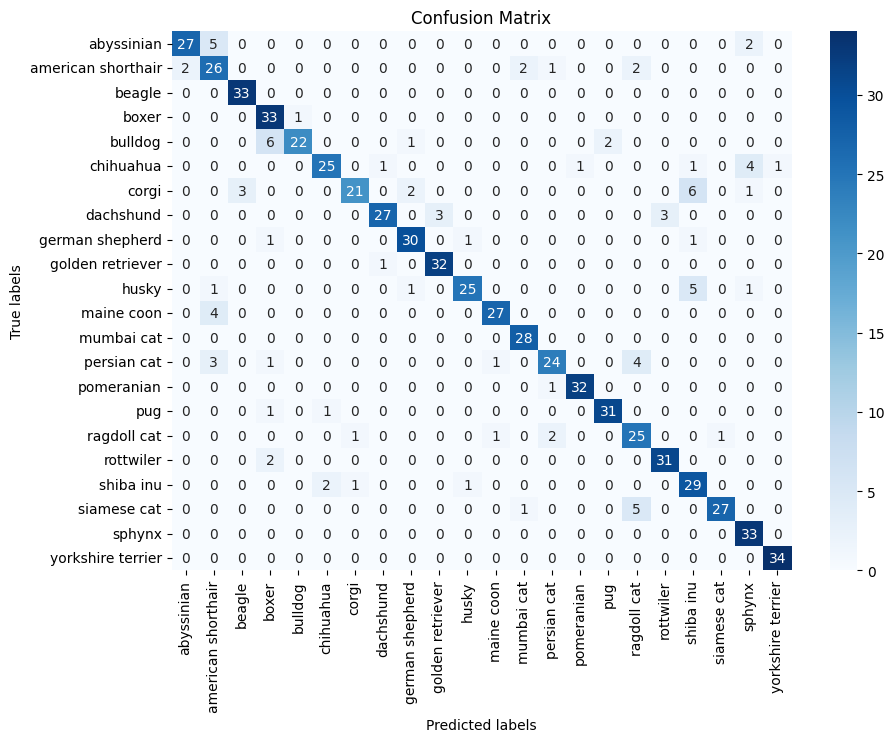

In [55]:
## Model Evaluation
evaluate_model(resnet,test_dataloader)